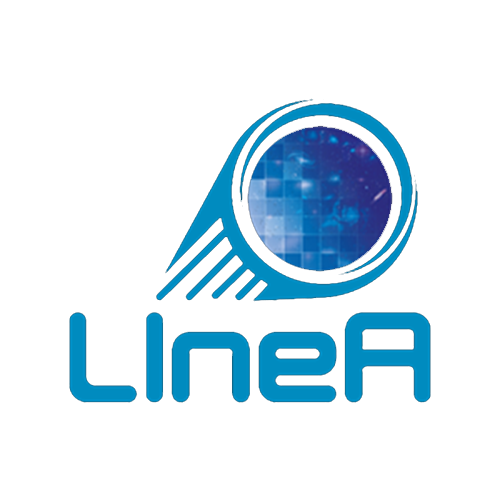

# Data Preparation on LSST DP0.2 (Object) Skinny catalog
## Merging the LSST DP0.2 (Object) Skinny, Matches Truth and Truth Catalogs

Doing a LEFT type join with LSST DP0.2 (Object) Skinny, Matches Truth and Truth Catalogs (keeping all LSST DP0.2 (Object) Skinny objects).

Author: Luigi Lucas de Carvalho Silva (luigi.lcsilva@gmail.com)

Last checked: Apr. 01, 2025

# Imports

In [ ]:
################################### GENERAL ##########################################
import os
import gc
import re
import glob
import time
import math
import shutil
import numpy as np
import pandas as pd
import getpass
from datetime import datetime

##################################### DASK ###########################################
from dask import config as dask_config_class
from dask import dataframe as dd
from dask import delayed, compute
from dask.distributed import Client, performance_report, wait
from dask_jobqueue import SLURMCluster

# Setups

## General libraries setup

## General paths setup

In [ ]:
current_date = datetime.now().strftime('%Y-%m-%d_%H-%M')

In [ ]:
user = getpass.getuser()
user_base_path = f'/lustre/t0/scratch/users/{user}/dp02_object_data_preparation'

In [ ]:
os.makedirs(user_base_path, exist_ok=True)

run_path = os.path.join(user_base_path, f'DP2_run_{current_date}')
os.makedirs(run_path, exist_ok=True)

data_dir = os.path.join(run_path, f'data')
os.makedirs(data_dir, exist_ok=True)

logs_dir = os.path.join(run_path, f'logs')
os.makedirs(logs_dir, exist_ok=True)

dask_logs_dir = os.path.join(run_path, f'dask_logs')
os.makedirs(dask_logs_dir , exist_ok=True)

## General data preparation setups

In [ ]:
### OBJECT CATALOG
object_folder = f"/lustre/t0/scratch/users/{user}/<path-to-your-object-catalog>"
object_pattern = '*.parquet'
#object_pattern = 'objectTable_tract_507*'
object_files = [f for f in glob.glob(os.path.join(object_folder, object_pattern))]

object_selected_columns = ['objectId',  'coord_ra', 'coord_dec', 'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y',
                           'magerr_u', 'magerr_g', 'magerr_r', 'magerr_i', 'magerr_z', 'magerr_y', 'detect_isPrimary', 'refExtendedness', 'tract', 'patch']

### MATCHES TRUTH CATALOG
matches_truth_folder = '/lustre/t1/cl/lsst/dp02/primary/catalogs/matches_truth'
matches_truth_pattern = '*.parq'
#matches_truth_pattern = 'match_ref_truth_summary_objectTable_tract_507*.parq'
matches_truth_files = [f for f in glob.glob(os.path.join(matches_truth_folder, matches_truth_pattern))]

matches_truth_columns = ['id', 'truth_type', 'match_objectId']

### TRUTH SUMMARY CATALOG
truth_folder = '/lustre/t1/cl/lsst/dp02/primary/catalogs/truth_summary/truth_match'
truth_pattern = '*.parquet'
#truth_pattern = 'truth_tract507*.parquet'
truth_files = [f for f in glob.glob(os.path.join(truth_folder, truth_pattern))]

truth_columns = ['id', 'truth_type', 'ra', 'dec', 'redshift']


DP_save_the_data = True

## General cluster setup

In [ ]:
CLUSTER_save_the_dask_jobs_info = True
CLUSTER_extra_dask_configs = False
CLUSTER_close_the_cluster_in_the_end = True

In [ ]:
if CLUSTER_extra_dask_configs == True:
    # Additional Dask configurations
    dask_config = {
        "distributed.worker.memory.target": 0.75,         # 75% before starting memory collection
        "distributed.worker.memory.spill": 0.85,          # 85% before starting to use disk
        "distributed.worker.memory.pause": 0.92,          # Pause the worker at 92%
        "distributed.worker.memory.terminate": 0.98,      # Restart the worker at 98%
        "distributed.worker.memory.recent-to-old": 0.2    # Keep 20% of recent data in memory
    }

    # Applying the Dask configurations
    dask_config_class.set(dask_config)
else:
    print("Running DASK with the standard memory configuration.")

In [ ]:
interface="ib0"
queue='cpu'
cores=50              #90% of one XL170r cores.         
processes=1       
memory='115GB'        #90% of one XL170r memory.
walltime='01:00:00'
account='hpc-bpglsst'

# When we use dask cluster.scale(), dask will reserve the resources for each worker in the physical nodes. 
# However, assuming the request of one process (worker) per cluster.scale() block, if a physical node has the double of the worker
# requested resource, for example, dask will place two workers in that node (two "blocks"). So, the variable dask_scale_number 
# here can be bigger than the number of physical nodes.
dask_scale_number = 26  # 70% of the maximum, considering the workers requested resources above.
                        # Assuming full cluster availability, Dask will place 14 workers on 14 XL170r physical nodes and 12 workers on 6 XL220n nodes, 
                        # because the XL220n nodes have approximately the double of resources of the XL170r nodes.

# Initializing the Cluster

In [ ]:
current_date = datetime.now().strftime('%Y-%m-%d_%H-%M')

if CLUSTER_save_the_dask_jobs_info:
    job_extra_directives=[
        '--propagate',
        f'--account={account}',
        f'--output={dask_logs_dir}/dask_job_%j_{current_date}.out',  
        f'--error={dask_logs_dir}/dask_job_%j_{current_date}.err',
    ]
else:
    job_extra_directives=[
        '--propagate',
        f'--account={account}',
        f'--output=/dev/null',  
        f'--error=/dev/null'
    ]

In [ ]:
# Configuring the SLURMCluster.
cluster = SLURMCluster(
    interface=interface,         # Lustre interface
    queue=queue,                 # Name of the queue
    cores=cores,                 # Number of logical cores per node
    processes=processes,         # Number of dask processes per node
    memory=memory,               # Memory per node
    walltime=walltime,           # Maximum execution time              
    job_extra_directives=job_extra_directives,
)

# Scaling the cluster to use X nodes
cluster.scale(jobs=dask_scale_number)

# Defining the dask client
client = Client(cluster)

# Wait for 90% of the workers to initialize
cluster.wait_for_workers(n_workers=(math.ceil(dask_scale_number * processes * 0.9)))
client.run(lambda: gc.collect())

In [ ]:
cluster_info = client.cluster
cluster_info

Saving the data.

In [ ]:
# === Saving cluster information ===
if DP_save_the_data:
    # Wait for the workers to be active to collect up-to-date data
    cluster_info = client.scheduler_info()
    workers = cluster_info["workers"]

    total_workers = len(workers)
    total_threads = sum(w["nthreads"] for w in workers.values())
    total_memory_GB = sum(w["memory_limit"] for w in workers.values()) / 1e9
    total_expected_workers = dask_scale_number * processes
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    cluster_text = f"""# ==== CLUSTER INFORMATION ====
    Execution timestamp: {timestamp}

    Lustre interface: {interface}
    SLURM queue: {queue}

    Requested dask cluster.scale() "blocks": {dask_scale_number}
    Cores per cluster.scale() "block": {cores}
    Processes (workers) per cluster.scale() "block": {processes}
    Memory per cluster.scale() "block": {memory}
    Walltime: {walltime}

    Active workers: {total_workers}
    Expected workers: {total_expected_workers}
    Total threads: {total_threads}
    Total allocated memory: {total_memory_GB:.2f} GB
    """

    cluster_path = os.path.join(logs_dir, "cluster_info.txt")
    with open(cluster_path, "w") as f:
        f.write(cluster_text)

    print(f"✅ Cluster information saved to: {cluster_path}")

# Reading and Merging the Dask Dataframes

Reading the catalogs with dask.

In [ ]:
ddf_object = dd.read_parquet(object_files, columns=object_selected_columns)
ddf_matches = dd.read_parquet(matches_truth_files, columns=matches_truth_columns)
ddf_truth = dd.read_parquet(truth_files, columns=truth_columns)

Generating the ```id_truth_type``` column and filtering the ```matches_truth``` and ```truth``` catalog.

In [ ]:
ddf_matches = ddf_matches[ddf_matches['match_objectId'] != -9223372036854775808]
ddf_matches = ddf_matches[~ddf_matches['id'].astype(str).str.startswith('MS')]

In [ ]:
ddf_matches['id_truth_type'] = (
    ddf_matches['id'].astype(str) + ddf_matches['truth_type'].astype(str)
).astype("int64")

ddf_truth['id_truth_type'] = (
    ddf_truth['id'].astype(str) + ddf_truth['truth_type'].astype(str)
).astype("int64")

In [ ]:
ddf_truth = ddf_truth.drop_duplicates(subset=['id_truth_type'])

Merging the catalogs.

In [ ]:
ddf_merged = ddf_object.merge(
    ddf_matches,
    left_on='objectId',
    right_on='match_objectId',
    how='left'  # keep all ddf_object objects
)

# Optional: .fillna(99.0)

In [ ]:
ddf_final = ddf_merged.merge(
    ddf_truth,
    on='id_truth_type',
    how='left'
)

# Optional: .fillna(99.0)

Dropping some duplicated columns.

In [ ]:
# Drop columns
ddf_final = ddf_final.drop(columns=["id_y", "truth_type_y", "match_objectId"])

# Rename columns
ddf_final = ddf_final.rename(columns={
    "id_x": "id",
    "truth_type_x": "truth_type"
})

In [ ]:
ddf_final = ddf_final.persist()

# Computing the Results and Saving

In [ ]:
target_rows_per_file = 130_000

In [ ]:
def extract_tracts_from_filenames(file_list):
    tract_set = set()
    pattern = re.compile(r'objectTable_tract_(\d+)_')

    for f in file_list:
        match = pattern.search(os.path.basename(f))
        if match:
            tract_set.add(int(match.group(1)))
    
    return sorted(tract_set)

In [ ]:
tract_values = extract_tracts_from_filenames(object_files)

In [ ]:
@delayed
def save_parts(df, tract_value):
    log_path = os.path.join(logs_dir, "dataframe_or_series_check.txt")
    should_log = not isinstance(df, pd.DataFrame) or len(df) == 0

    if should_log:
        with open(log_path, "a") as f:
            f.write(f"Tract {tract_value} - df is type: {type(df)}\n")
            try:
                f.write(f"Tract {tract_value} - len(df): {len(df)}\n")
            except Exception as e:
                f.write(f"Tract {tract_value} - error getting len(df): {e}\n")
            try:
                sample_parts = np.array_split(df, 1)
                if len(sample_parts) > 0:
                    f.write(f"Tract {tract_value} - first part_df type: {type(sample_parts[0])}\n")
                else:
                    f.write(f"Tract {tract_value} - first part_df: EMPTY split result\n")
            except Exception as e:
                f.write(f"Tract {tract_value} - error checking part_df type: {e}\n")

    total_rows = len(df)
    num_parts = max(1, round(total_rows / target_rows_per_file))
    
    for i, part_df in enumerate(np.array_split(df, num_parts)):
        filename = f"answerTable_tract_{tract_value}_DC2_2_2i_runs_DP0_2_v23_0_1_PREOPS-905_step3-part{i}.parquet"
        full_path = os.path.join(data_dir, filename)
        part_df.to_parquet(full_path, index=False)

    return f"Tract {tract_value} saved with {num_parts} parts"

In [ ]:
start_time = time.time()

save_tasks = []
for tract in tract_values:
    df_tract = ddf_final[ddf_final["tract"] == tract]
    save_tasks.append(save_parts(df_tract, tract))

compute(*save_tasks)

end_time = time.time()

In [ ]:
elapsed_seconds = end_time - start_time

hours, rem = divmod(elapsed_seconds, 3600)
minutes, seconds = divmod(rem, 60)
formatted_time = f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

tempo_log_path = os.path.join(logs_dir, 'execution_time.txt')
with open(tempo_log_path, 'w') as f:
    f.write(f"Total execution time: {formatted_time}\n")
    f.write(f"({elapsed_seconds:.2f} seconds)")

print(f"Total execution time: {formatted_time}\n")
print(f"({elapsed_seconds:.2f} seconds)")

# Validation

In [ ]:
expected_tracts = sorted(tract_values)

## Counting Tracts

In [ ]:
saved_tracts = []
for file in os.listdir(data_dir):
    match = re.search(r'answerTable_tract_(\d+)_', file)
    if match:
        saved_tracts.append(int(match.group(1)))
        
saved_tracts = sorted(set(saved_tracts))

missing = sorted(set(expected_tracts) - set(saved_tracts))

# Messages
msg_1 = f"✓ Expected tracts: {len(expected_tracts)}"
msg_2 = f"✓ Saved tracts:    {len(saved_tracts)}"
msg_3 = f"⚠️ Missing tracts:  {missing}"

# Print to console
print(msg_1)
print(msg_2)
print(msg_3)

# Save to file
log_file_path = os.path.join(logs_dir, "validation_counting_tracts.txt")
with open(log_file_path, "w") as f:
    f.write(msg_1 + "\n")
    f.write(msg_2 + "\n")
    f.write(msg_3 + "\n")

## Global

Reading the files.

In [ ]:
answer_catalog_folder = data_dir
answer_catalog_pattern = '*.parquet'

answer_catalog_files = [f for f in glob.glob(os.path.join(answer_catalog_folder, answer_catalog_pattern))]

In [ ]:
ddf_answer = dd.read_parquet(answer_catalog_files)

Doing a quickly global validation.

In [ ]:
ddf_answer_columns = ddf_answer.columns.to_list()
ddf_answer_unique_objectIds_number = ddf_answer['objectId'].nunique().compute()
ddf_answer_size = len(ddf_answer)
ddf_answer_head = ddf_answer.head()

timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

print("# ==== GLOBAL VALIDATION ====")
print(f"Timestamp: {timestamp}\n")

print("📄 Columns in answer catalog:")
print(ddf_answer_columns, "\n")

print("🔢 Number of unique objectIds:")
print(ddf_answer_unique_objectIds_number, "\n")

print("📏 Number of rows in answer catalog:")
print(ddf_answer_size, "\n")

print("👀 Preview (head):")
print(ddf_answer_head)


if DP_save_the_data:
    global_validation_text = f"""# ==== GLOBAL VALIDATION ====
    Timestamp: {timestamp}

    📄 Columns in answer catalog:
    {ddf_answer_columns}

    🔢 Number of unique objectIds:
    {ddf_answer_unique_objectIds_number}

    📏 Number of rows in answer catalog:
    {ddf_answer_size}

    👀 Preview (head):
    {ddf_answer_head.to_string(index=False)}
    """

    global_validation_path = os.path.join(logs_dir, "validation_global.txt")
    with open(global_validation_path, "w") as f:
        f.write(global_validation_text)

    print(f"\n✅ Global validation info saved to: {global_validation_path}")

## Specific

In [ ]:
def validate_files_by_tract(data_dir, tract_values, logs_dir):
    os.makedirs(logs_dir, exist_ok=True)
    log_path = os.path.join(logs_dir, "validation_specific.txt")

    errors = []
    logs = []

    for tract in tract_values:
        pattern = f"answerTable_tract_{tract}_*.parquet"
        files = glob.glob(os.path.join(data_dir, pattern))
        
        if not files:
            msg = f"[WARNING] No files found for tract {tract}"
            print(msg)
            logs.append(msg)
            continue

        try:
            ddf = dd.read_parquet(files)
            unique_tracts = ddf['tract'].unique().compute()

            if len(unique_tracts) != 1 or unique_tracts[0] != tract:
                msg = f"[ERROR] Tract {tract}: contains different values: {unique_tracts}"
                print(msg)
                logs.append(msg)
                errors.append((tract, unique_tracts.tolist()))
            else:
                msg = f"[OK] Tract {tract}: valid files"
                print(msg)
                logs.append(msg)
        
        except Exception as e:
            msg = f"[FAILURE] Tract {tract}: error reading files - {e}"
            print(msg)
            logs.append(msg)
            errors.append((tract, "read error"))

    # Save log to file
    with open(log_path, "w") as f:
        for line in logs:
            f.write(line + "\n")

    return errors

In [ ]:
# Run the validation
errors = validate_files_by_tract(data_dir, expected_tracts, logs_dir)

# Closing the cluster

In [ ]:
if CLUSTER_close_the_cluster_in_the_end:
    cluster.close()
    client.close()